### Comprehensive Performance Metrics for CNN Model

In [1]:
import numpy as np
import pandas as pd
from utils.constants import DATA_PATH, GLOVE_PATH

DATA_PATH

'/data'

In [2]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')

In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
from utils.functions import set_seed, build_vocab

# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200

In [5]:
from preprocess.data_loader import load_glove_embeddings

pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, embedding_dim)

In [6]:
from models.cnn import SpamCNN

# Load the trained CNN model
model_path = DATA_PATH + '/trained-models/spam_cnn_final.pt'
cnn_model = SpamCNN(vocab_size=len(word2idx), embedding_dim=embedding_dim,
                    pretrained_embeddings=pretrained_embeddings)
cnn_model.load(model_path, map_location=device)  # map_location handled in load()
cnn_model = cnn_model
cnn_model.eval()

SpamCNN(
  (embedding): Embedding(25245, 300)
  (conv1): Conv1d(300, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(64, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [7]:
from utils.functions import encode

# Prepare test data
X_test_tensor = torch.tensor([encode(t, word2idx, max_len) for t in test_df['text']])
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.float32)

# Move data to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [8]:
# Get model predictions
with torch.no_grad():
    y_pred_probs = cnn_model(X_test_tensor)
    y_pred = (y_pred_probs > 0.5).float()

In [9]:
from metrics.cnn_metrics import compute_metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Compute metrics - now returns a DataFrame
metrics_df = compute_metrics(y_test_tensor.cpu().numpy(), y_pred.cpu().numpy(), y_pred_probs.cpu().numpy())
metrics_df

,Value,Description,Optimal
Metric,,,
Accuracy,0.938944,Proportion of correct predictions (TP + TN) / ...,Higher better
Precision,0.932584,Proportion of true positives among predicted p...,Higher better
Recall (Spam Catch Rate),0.869110,Proportion of true positives among actual posi...,Higher better
F1-Score,0.899729,Harmonic mean of precision and recall,Higher better
Specificity (Ham Preservation Rate),0.971084,Proportion of true negatives among actual nega...,Higher better
False Positive Rate,0.028916,Proportion of false positives among actual neg...,Lower better
False Negative Rate,0.130890,Proportion of false negatives among actual pos...,Lower better
AUC-ROC,0.985725,Area under the Receiver Operating Characterist...,Higher better
Youden's J,0.840194,Recall + Specificity - 1,Higher better


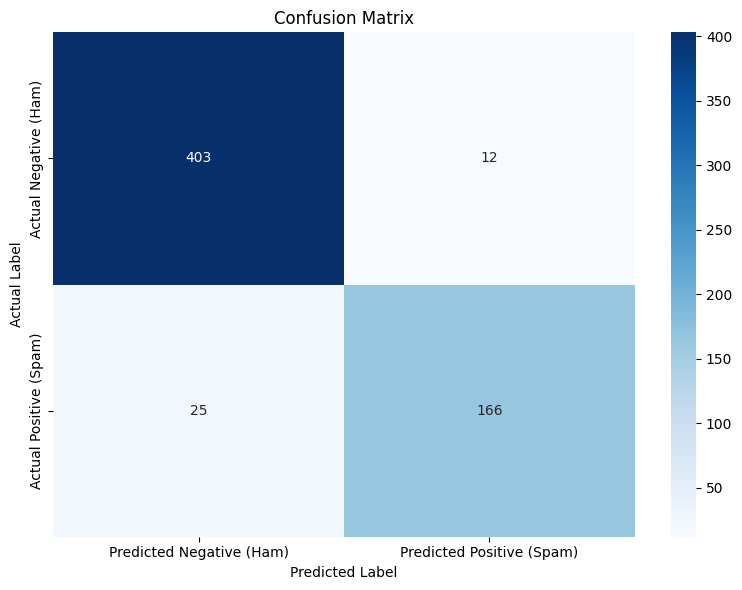


Confusion Matrix Details:
True Positives (TP): 166 - Correctly classified spam messages
True Negatives (TN): 403 - Correctly classified ham messages
False Positives (FP): 12 - Ham messages incorrectly classified as spam
False Negatives (FN): 25 - Spam messages incorrectly classified as ham


In [11]:
# Visualize the confusion matrix
confusion_matrix = metrics_df.attrs['confusion_matrix']

# Create a visual confusion matrix
cm_values = np.array([
    [confusion_matrix['tn'], confusion_matrix['fp']],
    [confusion_matrix['fn'], confusion_matrix['tp']]
])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_values, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Predicted Negative (Ham)', 'Predicted Positive (Spam)'],
           yticklabels=['Actual Negative (Ham)', 'Actual Positive (Spam)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Details:")
print(f"True Positives (TP): {confusion_matrix['tp']} - Correctly classified spam messages")
print(f"True Negatives (TN): {confusion_matrix['tn']} - Correctly classified ham messages")
print(f"False Positives (FP): {confusion_matrix['fp']} - Ham messages incorrectly classified as spam")
print(f"False Negatives (FN): {confusion_matrix['fn']} - Spam messages incorrectly classified as ham")